# scRNAsed seqFISH integration

Objectives:
- try to map non spatial scRNAseq data to spatial seqFISH data
- find the minimum number of genes required for this mapping
- investigate on whether there are some signatures in non spatial scRNAseq data about the spatial organisation of cells

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from path import Path

In [2]:
%qtconsole

In [3]:
data_dir = Path("../data/tasic_scRNAseq/")
scRNAseq_path = data_dir / "tasic_training_b2.txt"
seqFISH_path = data_dir / "seqfish_cortex_b2_testing.txt"
scRNAseq_labels_path = data_dir / "tasic_labels.tsv"
seqfish_labels_path = data_dir / "seqfish_labels.tsv"
seqFISH_coords_path = data_dir / "fcortex.coordinates.txt"

### scRNAseq data

txt file of normalized scRNAseq data for `113 genes x 1723 cells`

In [4]:
scRNAseq = pd.read_csv(scRNAseq_path, sep='\t', header=None, index_col=0)
scRNAseq.index.name= 'genes'
scRNAseq = scRNAseq.transpose()
scRNAseq.index.name = 'cells'
scRNAseq.head()

genes,abca15,abca9,acta2,adcy4,aldh3b2,amigo2,ankle1,ano7,anxa9,arhgef26,...,spag6,sumf2,tbr1,tnfrsf1b,vmn1r65,vps13c,wrn,zfp182,zfp715,zfp90
cells,,,,,,,,,,,,,,,,,,,,,
1,11.0,22.0,15.0,12.0,27.0,23.0,29.0,11.0,15.0,59.0,...,42.0,42.0,39.0,28.0,59.0,32.0,40.0,51.0,40.0,72.0
2,42.0,46.0,47.0,45.0,49.0,43.0,46.0,42.0,48.0,43.0,...,45.0,59.0,41.0,66.0,39.0,31.0,43.0,43.0,41.0,49.0
3,17.0,22.0,15.0,12.0,27.0,101.0,72.0,16.0,15.0,75.0,...,42.0,67.0,41.0,19.0,52.0,38.0,40.0,53.0,41.0,73.0
4,42.0,46.0,42.0,45.0,49.0,43.0,37.0,42.0,42.0,43.0,...,48.0,39.0,43.0,64.0,22.0,34.0,47.0,80.0,43.0,49.0
5,35.0,39.0,34.0,38.0,42.0,72.0,61.0,34.0,33.0,36.0,...,45.0,33.0,41.0,34.0,23.0,34.0,45.0,43.0,41.0,46.0


### seqFISH data

txt file of normalized seqFISH data for `113 genes x 1597 cells`

In [5]:
seqFISH = pd.read_csv(seqFISH_path, sep='\t', header=None, index_col=0)
seqFISH.index.name= 'genes'
seqFISH = seqFISH.transpose()
seqFISH.index.name = 'cells'
seqFISH.head()

genes,abca15,abca9,acta2,adcy4,aldh3b2,amigo2,ankle1,ano7,anxa9,arhgef26,...,spag6,sumf2,tbr1,tnfrsf1b,vmn1r65,vps13c,wrn,zfp182,zfp715,zfp90
cells,,,,,,,,,,,,,,,,,,,,,
1,68.0,41.0,25.0,39.0,101.0,93.0,41.0,44.0,53.0,38.0,...,41.0,36.0,101.0,61.0,38.0,63.0,36.0,97.0,32.0,35.0
2,49.0,42.0,23.0,54.0,47.0,64.0,42.0,68.0,40.0,40.0,...,101.0,36.0,101.0,42.0,39.0,31.0,38.0,35.0,33.0,35.0
3,50.0,38.0,16.0,37.0,41.0,93.0,76.0,50.0,43.0,42.0,...,39.0,46.0,101.0,33.0,54.0,43.0,31.0,36.0,86.0,46.0
4,39.0,36.0,21.0,18.0,52.0,93.0,40.0,48.0,39.0,45.0,...,39.0,33.0,101.0,49.0,60.0,34.0,51.0,36.0,18.0,37.0
5,31.0,47.0,29.0,37.0,101.0,93.0,46.0,50.0,31.0,46.0,...,62.0,0.0,101.0,28.0,51.0,47.0,24.0,26.0,35.0,40.0


### scRNAseq labels

tsv file of cell type labels for scRNAseq

In [6]:
scRNAseq_labels = pd.read_csv(scRNAseq_labels_path, sep='\t', header=None)
scRNAseq_labels.head()

,0,1,2
0,Astrocyte,Calb2_tdTpositive_cell_46,upper
1,Astrocyte,Calb2_tdTpositive_cell_48,upper
2,Astrocyte,Calb2_tdTpositive_cell_50,lower
3,Astrocyte,Calb2_tdTpositive_cell_53,lower
4,Astrocyte,Calb2_tdTpositive_cell_58,lower


In [7]:
phenotypes = list(scRNAseq_labels.iloc[:,0].unique())
print(phenotypes)

['Astrocyte', 'GABA-ergic Neuron', 'Endothelial Cell', 'Glutamatergic Neuron', 'Microglia', 'Oligodendrocyte.3', 'Oligodendrocyte.2', 'Oligodendrocyte.1']


### seqFISH coordinates

Spatial cell coordinates

In [8]:
seqFISH_coords = pd.read_csv(seqFISH_coords_path, sep=' ', header=None, usecols=[2,3], names=['x','y'])
seqFISH_coords.head()

,x,y
0,265.76,-231.14
1,290.48,-261.52
2,257.12,-133.35
3,753.46,-261.14
4,700.01,-169.05


## Exploratory Data Analysis

In [9]:
# label re-encoding

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(phenotypes)

y_true = le.transform(scRNAseq_labels.iloc[:,0])

# for coloring phenotypes on UMAPprojections
colors = [sns.color_palette()[x] for x in y_true]

In [10]:
import umap
# if not installed run: conda install -c conda-forge umap-learn

reducer = umap.UMAP()
embedding = reducer.fit_transform(scRNAseq)
embedding.shape

(1723, 2)

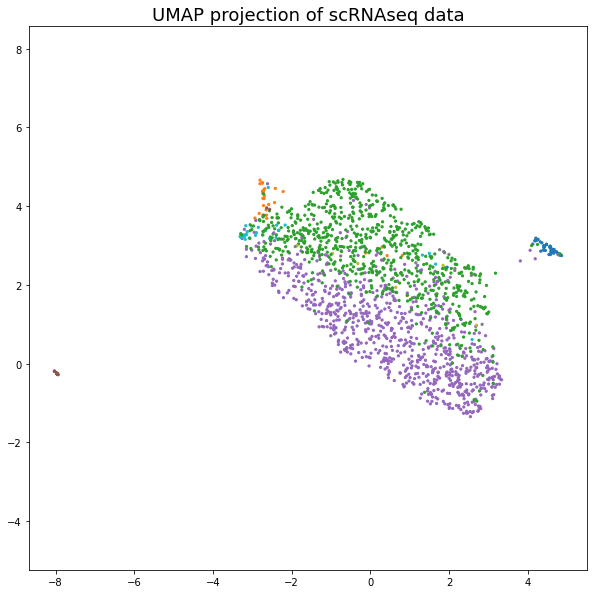

In [11]:
size_points = 5.0
colormap = 'tab10'
marker='o'

plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_true, cmap=colormap, marker=marker, s=size_points)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of scRNAseq data', fontsize=18);

On the reduced space the clusterization doesn't seem optimal, some groups are spread among different 'clouds' of points and some points are in the middle of another group.  
But for exploratory analysis for this challenge we stick to the cluster definition of *Tasic et al.*

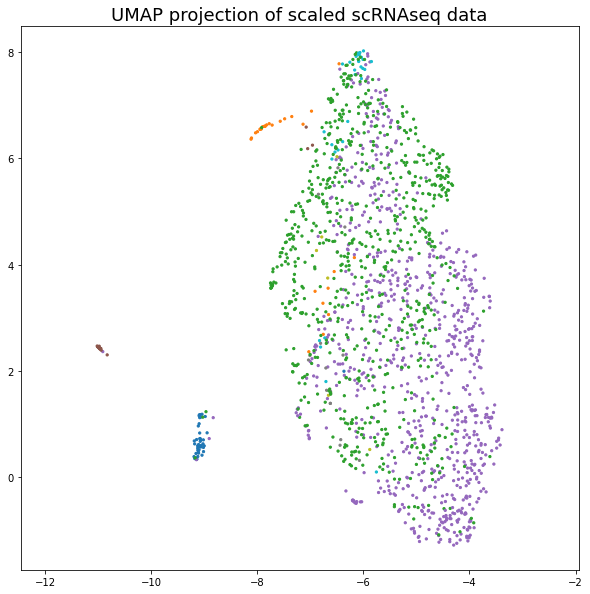

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(scRNAseq)

reducer = umap.UMAP()
embedding = reducer.fit_transform(X)
embedding.shape

plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c=y_true, cmap=colormap, marker=marker, s=size_points)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of scaled scRNAseq data', fontsize=18);

The mixing between the two main phenotypes in the main cloud seems even worse after standardization, but hopefuly it's only due to the projection on the 2D space for visualisation, and maybe they are very separable in higher dimensional spaces.

## Test kNN

To test the minimum number of genes required for cell phenotype classification, we try quickly the k-nearest neighbors model.

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

clf = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(clf, X, y_true, cv=10)
scores

/home/alexis/Programmes/Anaconda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


array([0.76300578, 0.90751445, 0.8150289 , 0.80232558, 0.86627907,
       0.84302326, 0.86046512, 0.9127907 , 0.83139535, 0.88953488])

In [14]:
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.85 (+/- 0.09)


The performance of kNN is pretty poor, we use the Support Vector Classifier

## Find optimal hyperparameters for SVC

We use the same classifier as in *Zhu et al* for this exploratory anaysis, but ideally we should test a lot of different classifiers with hyperparameter search for each of them.

In [ ]:
from time import time
from scipy.stats import loguniform
from sklearn.svm import SVC

clf = SVC()

# specify parameters and distributions to sample from
param_dist = {'C': loguniform(1e-2, 1e1),
              'gamma': loguniform(1e-2, 1e1)}

# run randomized search
n_iter_search = 50
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   n_jobs=7,
                                   scoring='accuracy')

start = time()
random_search.fit(X, y_true)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

report(random_search.cv_results_)

### Top-down elimination of variables

In [ ]:
# If you want to run the LONG top-down elimination of variables, uncomment and run this:

# clf = SVC(C=9.32, gamma=0.0157)
# Xelim = np.copy(X) # the X data that will be pruned

# elimination_report = []

# Nvar = X.shape[1]
# for i in range(Nvar-1):
#     print("Removing {} variables".format(i+1), end="    ")
#     scores = []
#     for var in range(Xelim.shape[1]):
#         # we remove only one variabme at a time
#         Xtest = np.delete(Xelim, var, axis=1)
#         score = cross_val_score(clf, Xtest, y_true, cv=5, n_jobs=5).mean()
#         #print("var {}/{}: {}".format(var+1, Xelim.shape[1], score))
#         scores.append(score)
        
#     # find the variable that was the less usefull for the model
#     maxi_score = max(scores)
#     worst_var = scores.index(maxi_score)
#     print("eliminating var n°{}, the score was {:.3f}".format(worst_var, maxi_score))
#     elimination_report.append([worst_var, maxi_score])
#     # eliminate this variable for next round
#     Xelim = np.delete(Xelim, worst_var, axis=1)

# elimination_report = np.array(elimination_report)
# np.savetxt("./elimination_report.csv", elimination_report, delimiter=',', header='var index, score', comments='', fmt=['%d', '%f'])

In [20]:
# If you want to load the data to display them directly, run this:
elimination_report = np.loadtxt("./elimination_report.csv", skiprows=1, delimiter=',')

Text(0, 0.5, 'score')

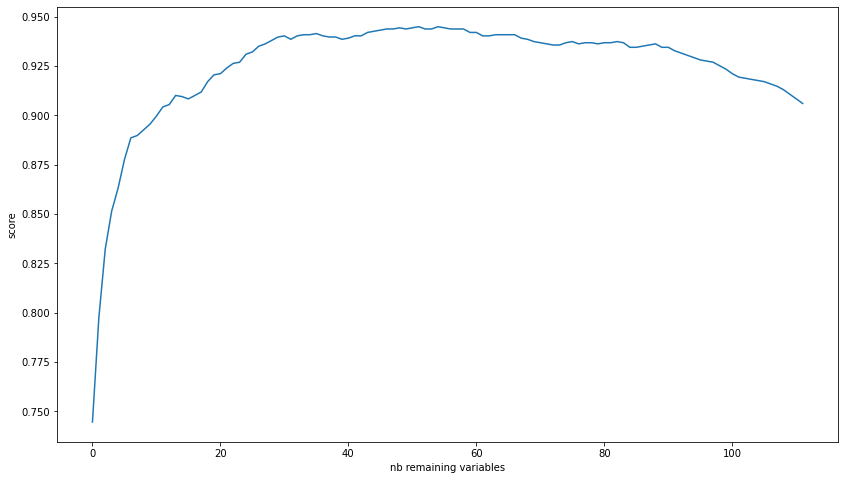

In [21]:
plt.figure(figsize=(14,8))
plt.plot(elimination_report[::-1,1]);
plt.xlabel('nb remaining variables')
plt.ylabel('score')

First the funny thing is that the score is non monotonic wrt the number of remaining variables.  
It looks like we could keep only 29 genes! (last maximum) 

### Infer cell types from restricted gene list

In [22]:
# Keep the inimum number of genes that lead to good predictions
genes_elim = elimination_report[:-28,0].astype(int)
# so probably it is actually not necessary to scale the data
# but for this notebook we will be consistent with the above analysis
Xtest = scaler.transform(scRNAseq)
Xpred = scaler.transform(seqFISH)  
for i in genes_elim:
    Xtest= np.delete(Xtest, i, axis=1)
    Xpred= np.delete(Xpred, i, axis=1)

In [23]:
clf = SVC(C=9.32, gamma=0.0157)
clf.fit(Xtest, y_true)
y_pred = clf.predict(Xpred)

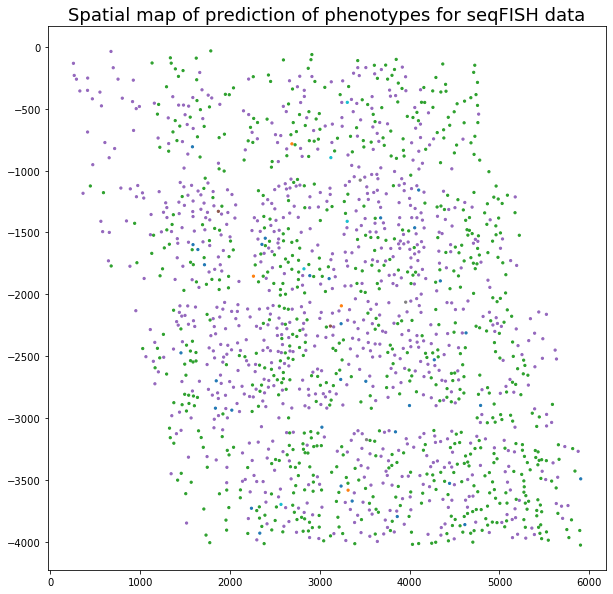

In [24]:
plt.figure(figsize=[10,10])
plt.scatter(seqFISH_coords.loc[:,'x'], seqFISH_coords.loc[:,'y'], c=y_pred, cmap=colormap, marker=marker, s=size_points)
plt.title('Spatial map of prediction of phenotypes for seqFISH data', fontsize=18);

## Spatial analysis

### Network reconstruction

In [25]:
from scipy.spatial import Voronoi

vor = Voronoi(seqFISH_coords[['x','y']])

# arrays of x0, y0, x1, y1
voro_cells = np.zeros((vor.ridge_points.shape[0],4))
voro_cells[:,[0,1]] = seqFISH_coords.loc[vor.ridge_points[:,0], ['x','y']]
voro_cells[:,[2,3]] = seqFISH_coords.loc[vor.ridge_points[:,1], ['x','y']]
distances = np.sqrt((voro_cells[:,0]-voro_cells[:,2])**2+(voro_cells[:,1]-voro_cells[:,3])**2)

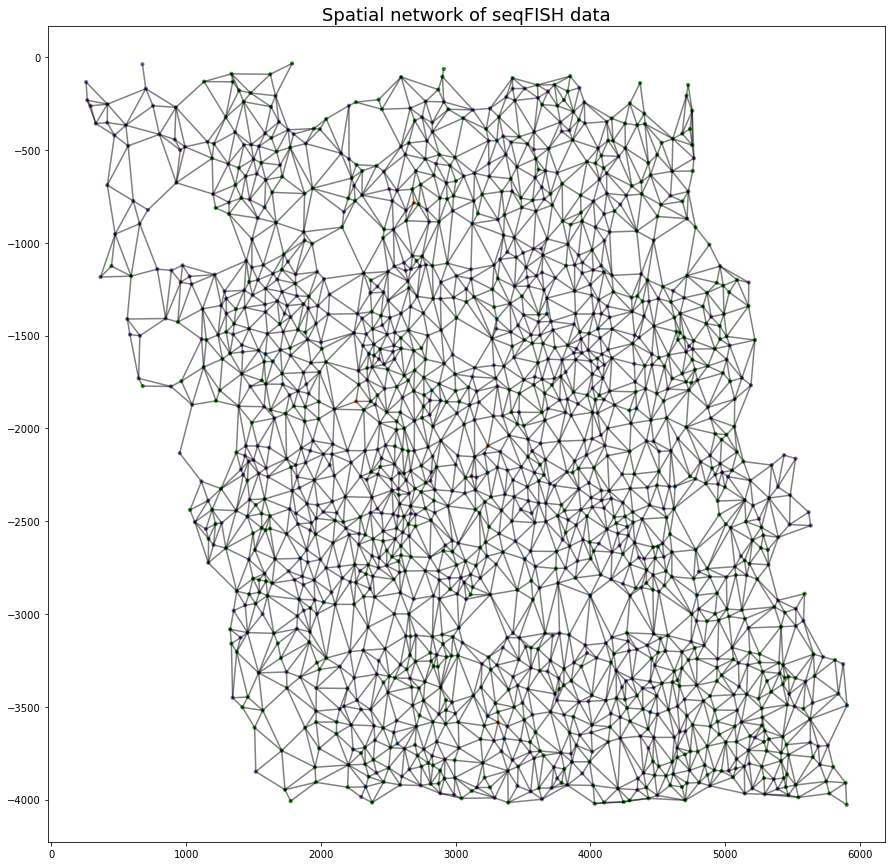

In [26]:
EDGE_DIST_THRESH = 300 # distance threshold to discard edges below it
selection = distances < EDGE_DIST_THRESH

plt.figure(figsize=[15,15])
for points in voro_cells[selection,:]:
    plt.plot(points[[0,2]],points[[1,3]], 'k-', alpha=0.5)
plt.scatter(seqFISH_coords.loc[:,'x'], seqFISH_coords.loc[:,'y'], c=y_pred, cmap=colormap, marker=marker, s=10)
plt.title('Spatial network of seqFISH data', fontsize=18);

I have to fix the colour display of the nodes... :-/

The next step is, for each node, look at its neighboors, and aggregate in some way their gene expression data.  
In the first place I think about mean and variance in order to capture the (non)homogeneity of cell types in the area.

### Neighbors gene expression aggregation

In [27]:
nb_cells = Xtest.shape[0]
nb_genes = Xtest.shape[1]
genes_aggreg = np.zeros((nb_cells, nb_genes*2)) # *2 because mean and variance are stored
pair_points = vor.ridge_points[selection,:]

for i in range(nb_cells):
    left_neigh = pair_points[pair_points[:,1] == i, 0]
    right_neigh = pair_points[pair_points[:,0] == i, 1]
    # array of all neighboors of node i
    neigh = np.hstack( (left_neigh, right_neigh) ).flatten()
    
    if neigh.size != 0:
        genes_aggreg[i,:nb_genes] = Xtest[neigh,:].mean(axis=0)
        genes_aggreg[i,-nb_genes:] = Xtest[neigh,:].std(axis=0)
    else:
        genes_aggreg[i,:] = None

error_cells = np.isnan(genes_aggreg[:,0])
nb_errors = error_cells.sum()
print(f"There has been {nb_errors}/{nb_cells} cells set to NaN")

There has been 126/1723 cells set to NaN


In [28]:
neigh_valid = genes_aggreg[~error_cells,:]

### Neighbors aggregated genes visualization

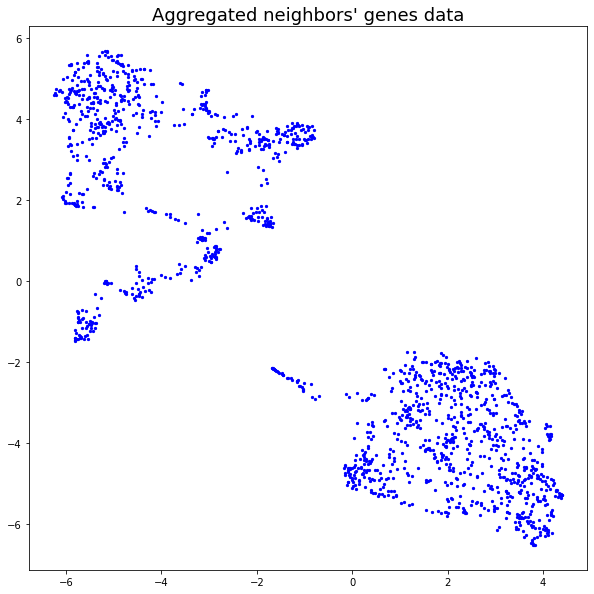

In [29]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(neigh_valid)
embedding.shape

plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='blue', marker=marker, s=size_points)
plt.title("Aggregated neighbors' genes data", fontsize=18);

It looks like we can define some clusters :)

### Neighboors aggregated genes clustering

Now we can use our favorite clustering algorithm to find groups of similar points: HAC, OPTICS or HDBSCAN for instance.

#### HDBSCAN

In [30]:
import hdbscan

clusterer = hdbscan.HDBSCAN(metric='euclidean', min_cluster_size=20)
clusterer.fit(neigh_valid)
print("HDBSCAN has detected {} clusters".format(clusterer.labels_.max()))

HDBSCAN has detected 1 clusters


That isn't good at all!  
We can try another algorithm

#### OPTICS

Defaults values are:  
`OPTICS(min_samples=5, max_eps=inf, metric='minkowski', p=2, metric_params=None, cluster_method='xi', eps=None, xi=0.05, predecessor_correction=True, min_cluster_size=None, algorithm='auto', leaf_size=30, n_jobs=None)`  
a minkowsky distance with `p=2` is the euclidian distance, so that's fine

In [31]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

clust = OPTICS()
# Run the fit
clust.fit(neigh_valid)

OPTICS(algorithm='auto', cluster_method='xi', eps=None, leaf_size=30,
       max_eps=inf, metric='minkowski', metric_params=None,
       min_cluster_size=None, min_samples=5, n_jobs=None, p=2,
       predecessor_correction=True, xi=0.05)

In [32]:
clust.labels_.max()

3

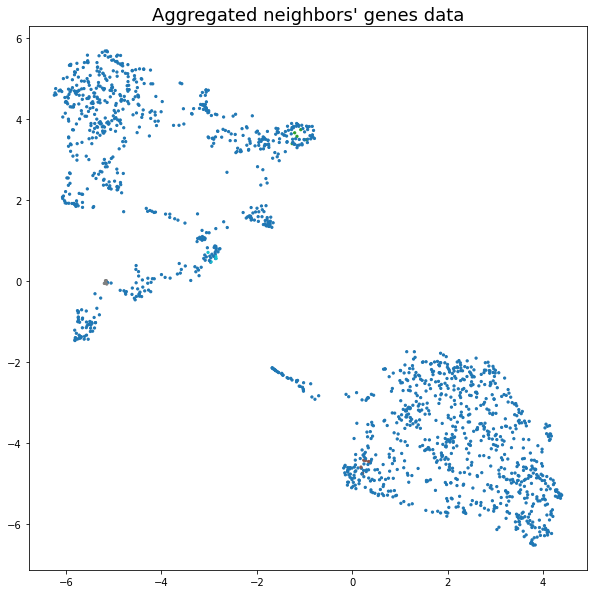

In [33]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c=clust.labels_, cmap=colormap, marker=marker, s=size_points)
plt.title("Aggregated neighbors' genes data", fontsize=18);

That is not much better!  

We should perform the clusterization on the reduced space, although it should be done with a lot of precautions (distances are not straighforwardly interpretable)

#### HDBSCAN on reduced space

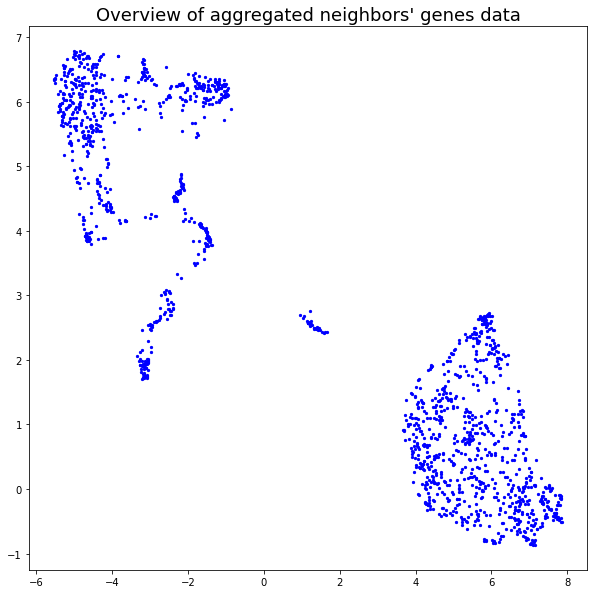

In [34]:
embedding = umap.UMAP(n_neighbors=30,
                      min_dist=0.0,
                      n_components=2,
                      random_state=42,
                      ).fit_transform(neigh_valid)

plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c='blue', marker=marker, s=size_points)
plt.title("Overview of aggregated neighbors' genes data", fontsize=18);

In [35]:
import hdbscan

clusterer = hdbscan.HDBSCAN(metric='euclidean', min_cluster_size=20, min_samples=1)
clusterer.fit(embedding)
print("HDBSCAN has detected {} clusters".format(clusterer.labels_.max()))

HDBSCAN has detected 10 clusters


we choose `min_samples=1` to avoid having points considered as noise

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


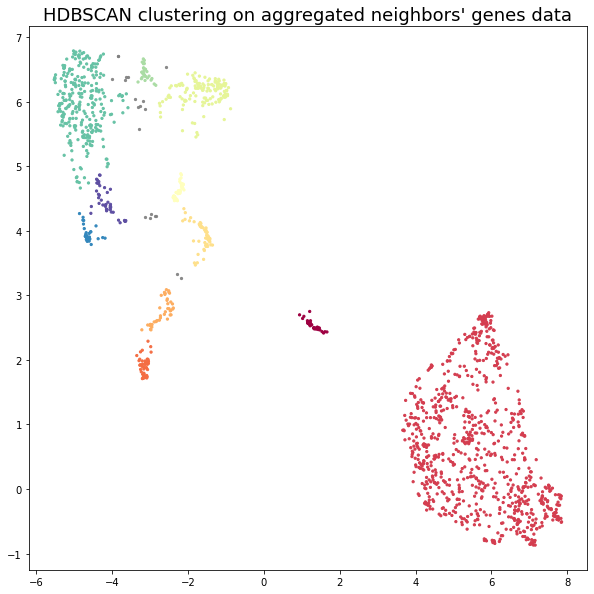

In [36]:
labels = clusterer.labels_
clustered = (labels >= 0)
plt.figure(figsize=[10,10])
plt.scatter(embedding[~clustered, 0],
            embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=5,
            alpha=0.9)
plt.scatter(embedding[clustered, 0],
            embedding[clustered, 1],
            c=labels[clustered],
            s=5,
            cmap='Spectral');
plt.title("HDBSCAN clustering on aggregated neighbors' genes data", fontsize=18);

Of course one can tweak the parameters to obtain a clustering that fits him better.

#### OPTICS on reduced space

In [37]:
clust = OPTICS(min_cluster_size=50)
# Run the fit
clust.fit(embedding)

clust.labels_.max()

10

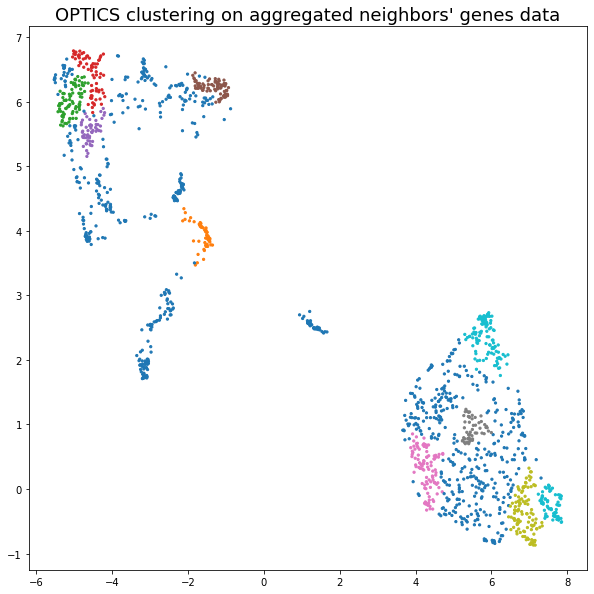

In [38]:
plt.figure(figsize=[10,10])
plt.scatter(embedding[:, 0], embedding[:, 1], c=clust.labels_, cmap=colormap, marker=marker, s=size_points)
plt.title("OPTICS clustering on aggregated neighbors' genes data", fontsize=18);

HDBSCAN provides a much better clustering regarding the data projection.

### Visualisation of spatial seqFISH data and detected areas 

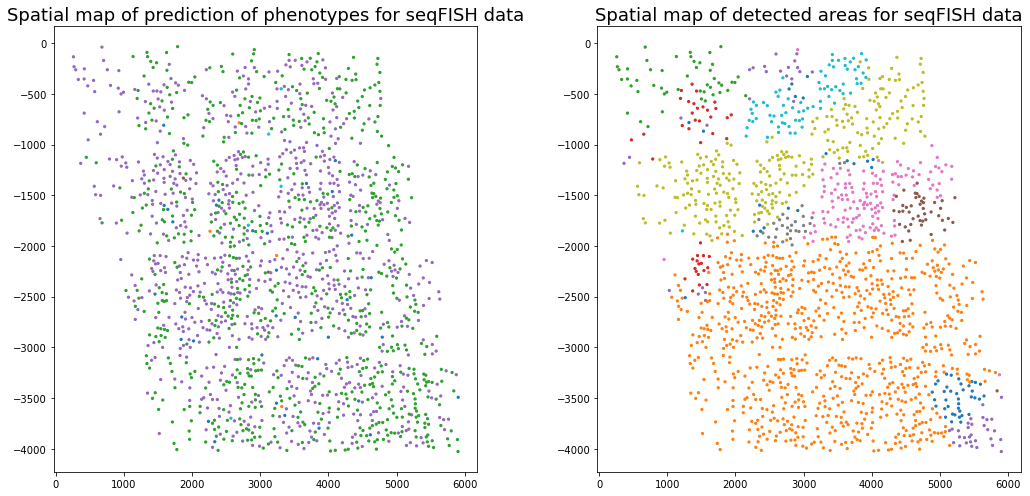

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15,7), tight_layout=True)
ax[0].scatter(seqFISH_coords.loc[:,'x'], seqFISH_coords.loc[:,'y'], c=y_pred, cmap=colormap, marker=marker, s=size_points)
ax[0].set_title('Spatial map of prediction of phenotypes for seqFISH data', fontsize=18);

ax[1].scatter(seqFISH_coords.loc[:,'x'], seqFISH_coords.loc[:,'y'], c=labels, cmap=colormap, marker=marker, s=size_points)
ax[1].set_title('Spatial map of detected areas for seqFISH data', fontsize=18);

The detected areas look plausible as points affected to different area types are not randomly dispersed.  
Moreover the detected areas span over areas of some phenotypes or form regions smaller than areas of some phenotypes.

## Conclusion

We have seen that it is possible to assign to seqFISH data points their corresponding phenotypes defined from the scRNAseq data, with only 29 genes.  

Moreover for seqFISH data aggregating gene expression for each node and it's neighbors we have found different groups, which migh correspond to areas of cell of different proportions in phenotypes.  
It would be interesting to check that in a further analysis.  

An interesting lead could be, for each cell, retrieve the mean values of its corresponding phenotype (the 'signature' of the phenotype), and then run again an aggregated neighbors' gene expression analysis. That could emphasise the genes that are under or over expressed due to the localisation of the cells and eliminate the strong contributions of genes that are specific of cell type.